## **Aprendizaje profundo con información clínica patológica**

Mi intención es facilitar lo mayor posible la corrección de este trabajo, siendo el apartado de tratamientos de datos sin cambiar tanto el código base del trabajo, pero agregando puntos que considero que facilitarán y mejoraran la creación de un modelo, estos puntos serán comentados y razonados en los bloques markdown que empiezan con **agregado**.

Bibliotecas

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # pip install seaborn
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler # pip install imbalanced-learn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold






Lectura del conjunto de datos

In [3]:
df = pd.read_csv("mort_hospital.csv")

**Problema**: Alto número de columnas con datos no informados

In [4]:
df.isnull().any().sum()

175

**Problema**: Presencia de variables no numéricas

In [5]:
object_columns = df.select_dtypes(include=['object']).columns
cols = df.select_dtypes([np.number]).columns
print("Columnas con datos categóricos:", len(object_columns))
print("Columnas con datos numéricos:", len(cols))

Columnas con datos categóricos: 8
Columnas con datos numéricos: 178


**Problema**: Las clases de la variable de interés están muy desequilibradas

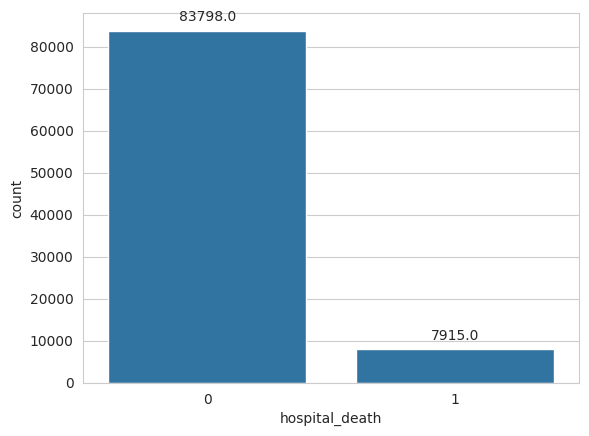

In [6]:
sns.set_style('whitegrid')
ax = sns.countplot(x='hospital_death', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

**Agregado:** El plot muestra ahora exactamente el número exacto de cada clase.

A continuación cree una función que estudia cuanto porcentaje de datos faltantes hay en cada variable, puesto que casos como `h1_bilirubin_min` que muestra un 92,27% de datos faltantes, rellenarlos con el promedio (por temas de legibilidad del markdown no puse los códigos donde evalue cada variable por separado, pero todas las que tienen más de un 50% de datos faltantes eran variables númericas), considero que esto en vez de ayudar a encontrar patrones en los datos con los que predecir puede causar sobrentrenamiento o percepción de patrones inexistentes.

Por lo que se uso un limite de aquellas variables con más de 50% datos faltantes serán borrados.

In [7]:

def eliminar_columnas_con_muchos_na(df, porcentaje_limite=50):
    """
    Estudia el porcentaje de valores NA en cada columna de un DataFrame y elimina las columnas que superen el porcentaje límite.

    Args:
        df: DataFrame de pandas.
        porcentaje_limite: Porcentaje límite de valores NA para eliminar una columna.

    Returns:
        DataFrame de pandas con las columnas eliminadas o el mismo DataFrame si no se eliminaron columnas.
    """

    # Calcular el porcentaje de valores NA en cada columna
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Ordenar las columnas por porcentaje de NA de mayor a menor
    missing_series = missing_percentage.sort_values(ascending=False)

    # Identificar las columnas a eliminar
    columnas_a_eliminar = missing_series[missing_series > porcentaje_limite].index

    # Eliminar las columnas si hay alguna que supere el límite
    if len(columnas_a_eliminar) > 0:
        print("Columnas eliminadas por superar el límite de NA:")
        for column, percentage in missing_series[missing_series > porcentaje_limite].items():
            print(f"{column}: {percentage:.2f}%")

        print("\nColumnas que permanecen en el dataset:")
        for column, percentage in missing_series[missing_series <= porcentaje_limite].items():
            print(f"{column}: {percentage:.2f}%")

        df = df.drop(columns=columnas_a_eliminar)
    else:
        print("Todas las columnas tienen un porcentaje de NA aceptable.")

    return df



df = eliminar_columnas_con_muchos_na(df,25)

Columnas eliminadas por superar el límite de NA:
h1_bilirubin_min: 92.27%
h1_bilirubin_max: 92.27%
h1_lactate_max: 91.99%
h1_lactate_min: 91.99%
h1_albumin_max: 91.40%
h1_albumin_min: 91.40%
h1_pao2fio2ratio_min: 87.44%
h1_pao2fio2ratio_max: 87.44%
h1_arterial_ph_max: 83.33%
h1_arterial_ph_min: 83.33%
h1_hco3_max: 82.97%
h1_hco3_min: 82.97%
h1_arterial_pco2_min: 82.82%
h1_arterial_pco2_max: 82.82%
h1_wbc_max: 82.82%
h1_wbc_min: 82.82%
h1_arterial_po2_max: 82.81%
h1_arterial_po2_min: 82.81%
h1_calcium_max: 82.72%
h1_calcium_min: 82.72%
h1_platelets_max: 82.51%
h1_platelets_min: 82.51%
h1_bun_max: 81.88%
h1_bun_min: 81.88%
h1_creatinine_max: 81.73%
h1_creatinine_min: 81.73%
h1_diasbp_invasive_min: 81.70%
h1_diasbp_invasive_max: 81.70%
h1_sysbp_invasive_max: 81.68%
h1_sysbp_invasive_min: 81.68%
h1_mbp_invasive_min: 81.61%
h1_mbp_invasive_max: 81.61%
h1_hematocrit_max: 80.05%
h1_hematocrit_min: 80.05%
h1_hemaglobin_min: 79.73%
h1_hemaglobin_max: 79.73%
h1_sodium_min: 79.18%
h1_sodium_max: 

**Agregado:** Recapitulación de información de las columnas, actualmente el dataframe cuenta con 70 columnas numéricas menos.

In [8]:
object_columns = df.select_dtypes(include=['object']).columns
cols = df.select_dtypes([np.number]).columns
print("Columnas con datos categóricos:", len(object_columns))
print("Columnas con datos numéricos:", len(cols))

Columnas con datos categóricos: 8
Columnas con datos numéricos: 104


Solución al problema de los datos no informados:
- Variables categóricas: rellenar con la moda
- Variables numéricas: rellenar con el promedio

In [9]:
for i in object_columns:
    df[i].fillna(df[i].mode()[0], inplace=True)

df[cols] = df[cols].fillna(df[cols].mean())

Solución al problema de las variables no numéricas:
- Codificación de variables categóricas

In [10]:
print("Valores de la variable 'etnicity' antes de la codificación:", df['ethnicity'].unique())
le = LabelEncoder()
df[object_columns] = df[object_columns].apply(le.fit_transform)
print("Valores de la variable 'etnicity' después de la codificación:", df['ethnicity'].unique())

Valores de la variable 'etnicity' antes de la codificación: ['Caucasian' 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
Valores de la variable 'etnicity' después de la codificación: [2 3 0 1 4 5]


Solución al problema del desequilibrio de la variable de interés:
- Muestreo de la clase más numerosa

In [13]:
X = df.drop(columns='hospital_death', axis=1)
y = df['hospital_death']

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

print("Recuento de categorías de salida:", Counter(y))

Recuento de categorías de salida: Counter({0: 7915, 1: 7915})


Selección de características

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)



Normalización de datos

Considero que el trabajo real empieza a partir de este punto, si quieres confirmar que mi entendimiento del código proporcionado puedes ver [mi repositorio github que hablo más a detalle en el readme](https://github.com/Diegodepab/Redes_aprendizaje_python_y_R/tree/main/Aprendizaje_profundo_con_informaci%C3%B3n_clinico-patologica) sobre el preprocesamiento de datos.

### Solución de la tarea 2
**Objetivos**
- Entender el código proporcionado: tratamiento de datos no informados, codificación de variables categóricas, equilibrado de categorías de la variable de interés, selección de características y normalización.
- Diseñar y entrenar una red neuronal para predecir la variable 'hospital_death':
    - Probar con distintos valores de 'num_k' para cambiar el número de características seleccionadas.
    - Diseñar un modelo secuencial ('Sequential()'), cuya primera capa debe especificar como 'input_dim' el valor 'num_k', probando distintos números de capas, funciones de activación (RELU y variantes para las capas ocultas, sigmoide para la capa final), número de neuronas en cada capa, capas 'Dropout', etc.
    - Compilar el modelo estableciendo una función de error ('loss'), el optimizador (puedes cambiar el parámetro 'learning_rate') y las métricas de rendimiento que se calcularán.
    - Ajustar el modelo con los datos de entrenamiento estableciendo para la función 'fit' el número de iteraciones ('epochs'), el porcentaje de datos de validación ('validation_split') y el tamaño de lote para la retropropagación ('batch_size').
- **OPCIONAL**: En lugar de cablear en el código los parámetros anteriores y modificarlos a mano, se valorará muy positivamente la escritura de un programa que genere dinámicamente diferentes arquitecturas probando distintos valores para todos o algunos de los parámetros del punto anterior.

Voy a plantear dos funciones para cumplir los objetivos deseados. La primera función probará distintos valores de num_k y transformará los datos en función de los mejores atributos seleccionados. La segunda diseñará el modelo secuencial con diferentes configuraciones, entrenará, y mostrará tanto la curva ROC como la precisión para determinar el mejor num_k.

###  Primera función: Selección de características

Antes de entrenar el modelo, es importante realizar una **selección adecuada de las características más relevantes** del conjunto de datos para mejorar el rendimiento del modelo. En este caso, se utilizará la función `SelectKBest` de `sklearn`, que selecciona las mejores características basándose en una métrica de información mutua. El parámetro k define cuántas características se deben seleccionar, y se probarán diferentes valores de k para encontrar la cantidad óptima de características.

El código que se presenta a continuación permite transformar los conjuntos de **entrenamiento** y **prueba** seleccionando las mejores características según los valores de k definidos. Posteriormente, los datos son estandarizados usando `StandardScaler` para asegurar que todas las características tengan la misma escala, lo que es fundamental para el buen desempeño del modelo. El resultado es un diccionario que contiene las transformaciones para cada valor de k, que luego se pueden usar en el entrenamiento y evaluación del modelo.

In [ ]:
def seleccionar_mejores_k(X_train, X_test, y_train, num_ks):
    resultados = {}

    for num_k in num_ks:
        # Seleccionar las mejores k características
        selector = SelectKBest(mutual_info_classif, k=num_k)
        selector.fit(X_train, y_train)

        # Transformar los datos de entrenamiento y prueba
        X_train_new = selector.transform(X_train)
        X_test_new = selector.transform(X_test)

        # Estandarización de los datos
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train_new)
        X_test_std = scaler.transform(X_test_new)

        # Almacenar los datos transformados
        resultados[num_k] = (X_train_std, X_test_std)

    return resultados

num_ks = [10, 15, 20, 25, 30, 35, 40, 45]
resultados_k = seleccionar_mejores_k(X_train, X_test, y_train, num_ks)
#print(resultados_k)

El resultado mostrado es un diccionario en el que cada clave representa un valor de `"k"`, que indica el número de características seleccionadas en el proceso de selección de las mejores características para el modelo. Para cada valor de `"k"`, se almacenan dos matrices: una para los datos de entrenamiento (`X_train_std`) y otra para los datos de prueba (`X_test_std`). Estas matrices contienen los datos transformados, donde las características seleccionadas han sido normalizadas (escaladas) para que tengan una media de 0 y una desviación estándar de 1. Esto permite que el modelo sea entrenado de manera más eficiente, eliminando el impacto de las diferentes escalas de las características originales. Cada conjunto de datos corresponde a una selección diferente de características según el valor de "`k`", lo que permite comparar cómo el número de características seleccionadas afecta al desempeño del modelo.

###  Evaluación de `num_k` y diseño de modelos

A continuación se lleva a cabo la evaluación del desempeño de **los modelos secuenciales** generados con diferentes valores de `num_k` anteriormente. Se utiliza un ciclo para probar cada conjunto de características seleccionadas, diseñando un modelo de red neuronal secuencial con diferentes capas, funciones de activación (ReLU para las capas ocultas y sigmoide para la capa de salida), y la inclusión de capas Dropout para evitar el sobreajuste.

El modelo se compila con una función de error (`binary_crossentropy`), un optimizador `Adam` con un `learning_rate` ajustable y se entrena con un número de épocas definidas y un tamaño de lote específico. Además, la función permite usar validación cruzada (Que se usará más adelante con los mejores resultados) para obtener una evaluación más robusta mediante la métrica ROC-AUC. El rendimiento de cada modelo se muestra a través de las métricas de ROC-AUC y precisión (accuracy). La función retorna el valor de num_k que ha mostrado el mejor desempeño en cuanto a ROC-AUC.

In [ ]:
def evaluar_k_modelos(resultados_k, y_train, y_test, use_cross_validation=False):
    mejor_k = None
    mejor_roc_auc = 0

    for num_k, (X_train_std, X_test_std) in resultados_k.items():
        # Diseñar el modelo secuencial
        model = Sequential()
        model.add(Dense(64, input_dim=num_k, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        # Compilación
        optimizer = Adam(learning_rate=0.001) #mejor learning rate conseguido en otras compilaciones
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        if use_cross_validation:
            # Validación cruzada
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_train_std, y_train, cv=kfold, scoring='roc_auc')
            roc_auc = scores.mean()
        else:
            # Entrenamiento sin validación cruzada
            model.fit(X_train_std, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            y_pred = model.predict(X_test_std).ravel()
            roc_auc = roc_auc_score(y_test, y_pred)

        accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))

        print(f"num_k: {num_k}, ROC-AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

        # Guardar el mejor k
        if roc_auc > mejor_roc_auc:
            mejor_roc_auc = roc_auc
            mejor_k = num_k
    return mejor_k

mejor_k = evaluar_k_modelos(resultados_k, y_train, y_test, use_cross_validation=False)
print(f"El mejor valor de num_k es: {mejor_k}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 10, ROC-AUC: 0.8699, Accuracy: 0.7887
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 15, ROC-AUC: 0.8716, Accuracy: 0.7960
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
num_k: 20, ROC-AUC: 0.8724, Accuracy: 0.7997
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 25, ROC-AUC: 0.8819, Accuracy: 0.8029
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 30, ROC-AUC: 0.8805, Accuracy: 0.8051
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 35, ROC-AUC: 0.8844, Accuracy: 0.8076
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 40, ROC-AUC: 0.8839, Accuracy: 0.8073
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
num_k: 45, ROC-AUC: 0.8840, Accuracy: 0.8042
El mejor valor de num_k es: 35


Ya una vez conseguido el mejor `num_k` se óptará por probar las mejores configuraciones para crear y entrenar un modelo:

### Función capaz de crear y entrenar el modelo


La función `create_and_train_model` crea y entrena un modelo de red neuronal utilizando la configuración de capas proporcionada (`layers_config`) y otros parámetros como la tasa de aprendizaje, la tasa de dropout, el número de épocas y el tamaño de lote. El modelo usa capas densas con activación `ReLU` para las *capas ocultas* y `sigmoide` para la* capa de salida,* aplicando *Dropout* para evitar el sobreajuste. También incorpora `EarlyStopping` para interrumpir el entrenamiento si no hay mejoras en la validación. Esta función se usará en otro bloque para probar diferentes configuraciones de redes neuronales.

In [ ]:
def create_and_train_model(X_train, y_train, X_val, y_val, num_k, layers, dropout_rate, learning_rate, epochs, batch_size, validation_split):
    # Crear el modelo secuencial
    model = Sequential()

    # Agregar capas ocultas
    for units in layers:
        model.add(Dense(units, activation='relu', input_dim=num_k))
        model.add(Dropout(dropout_rate))

    # Agregar capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        verbose=0  # Cambiar a 1 si se desea ver el progreso
    )

    # Evaluar el modelo en el conjunto de validación
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    return model, val_loss, val_accuracy

### Probar diferentes configuraciones

La función `optimize_neural_network` busca encontrar la mejor configuración para entrenar una *red neuronal*, probando todas las combinaciones posibles de parámetros de la red. Primero, normaliza los datos utilizando `StandardScaler` y los divide en conjuntos de entrenamiento y validación. Luego, itera a través de diferentes configuraciones de la red, como el número de capas, la tasa de dropout, la tasa de aprendizaje y el tamaño del lote. Para cada combinación de estos parámetros, entrena el modelo y evalúa su rendimiento en el conjunto de validación. Al final, guarda y devuelve la configuración que logró la mejor precisión en validación. Esta función es útil para realizar una búsqueda exhaustiva de hiperparámetros para optimizar el rendimiento del modelo.

In [ ]:


def optimize_neural_network(X, y, num_k, config_options):
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Seleccionar las primeras num_k características
    X_scaled = X_scaled[:, :num_k]

    # Dividir los datos en conjunto de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

    best_accuracy = 0
    best_model = None
    best_config = None

    # Búsqueda de todas las combinaciones posibles
    for layers in config_options['layers']:
        for dropout_rate in config_options['dropout_rates']:
            for learning_rate in config_options['learning_rates']:
                for batch_size in config_options['batch_sizes']:
                    for epochs in config_options['epochs']:
                        for validation_split in config_options['validation_splits']:
                            print(f"Probando configuración: Layers: {layers}, Dropout: {dropout_rate}, "
                                  f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, "
                                  f"Epochs: {epochs}, Validation Split: {validation_split}")

                            # Entrenar el modelo con la configuración actual
                            model, val_loss, val_accuracy = create_and_train_model(
                                X_train, y_train, X_val, y_val, num_k, layers,
                                dropout_rate, learning_rate, epochs, batch_size, validation_split
                            )

                            # Guardar la mejor configuración
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_model = model
                                best_config = (layers, dropout_rate, learning_rate, batch_size, epochs, validation_split)

    print(f"Mejor configuración encontrada: {best_config} con precisión de validación: {best_accuracy}")

    return best_model, best_config, best_accuracy

# Configuración de hiperparámetros
config_options = {
    'layers': [[128, 64], [256, 128]], #Descartados por tiempo d ecompilacion muy largos y resultados no tan prometedores para una validacion_ , [64, 32]
    'dropout_rates': [0.3], #,0.04, 0.5
    'learning_rates': [0.001, 0.0005], # , 0.0005, 0.1, 0.01
    'batch_sizes': [32, 64],
    'epochs': [100, 150], #50,
    'validation_splits': [0.2, 0.3] #0.1,
}

best_model, best_config, best_accuracy = optimize_neural_network(
    X, y, mejor_k, config_options=config_options
)


Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 32, Epochs: 100, Validation Split: 0.2
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 32, Epochs: 100, Validation Split: 0.3
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 32, Epochs: 150, Validation Split: 0.2
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 32, Epochs: 150, Validation Split: 0.3
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 64, Epochs: 100, Validation Split: 0.2
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 64, Epochs: 100, Validation Split: 0.3
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size: 64, Epochs: 150, Validation Split: 0.2
Probando configuración: Layers: [128, 64], Dropout: 0.3, Learning Rate: 0.001, Batch Size:

# Resultados finales

Columnas seleccionadas: Index(['apache_2_diagnosis', 'apache_3j_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache',
       'map_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_min', 'd1_mbp_min',
       'd1_mbp_noninvasive_min', 'd1_spo2_min', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_min', 'h1_sysbp_noninvasive_min',
       'd1_bun_max', 'd1_bun_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_hco3_max', 'd1_hco3_min', 'd1_wbc_max',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'apache_2_bodysystem'],
      dtype='object')
Número de características seleccionadas: 35
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


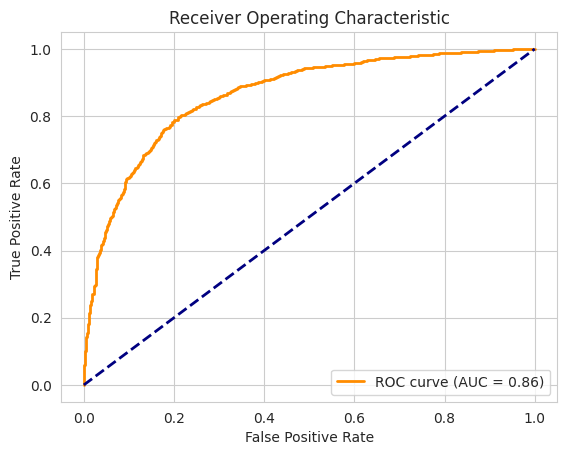

Accuracy: 0.7912
ROC AUC: 0.8647


In [27]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

def evaluar_modelo(num_k, X, y, mejor_config, use_cross_validation=False):
    """
    Esta función evalúa el modelo con la selección de las mejores 'k' características y
    muestra las métricas de desempeño como la curva ROC, accuracy y ROC AUC.
    """
    # Extraer la mejor configuración
    layers, dropout_rate, learning_rate, batch_size, epochs, validation_split = mejor_config

    # Selección de las mejores k características dentro de la función
    selector = SelectKBest(mutual_info_classif, k=num_k)
    X_selected = selector.fit_transform(X, y)

    # Crear un nuevo DataFrame con las características seleccionadas
    X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support(indices=True)])

    # Mostrar las columnas seleccionadas
    print(f"Columnas seleccionadas: {X_selected_df.columns}")

    # Paso 2: Estandarización de los datos
    scaler = StandardScaler()
    X_selected_std = scaler.fit_transform(X_selected)


    # Diseño del modelo
    model = Sequential()
    model.add(Dense(layers[0], input_dim=num_k, activation='relu'))
    model.add(Dropout(dropout_rate))

    for neurons in layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    # Compilación del modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Validación cruzada
    accuracies = []
    losses = []
    all_y_true = []
    all_y_pred = []

    if use_cross_validation:
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_index, val_index in kfold.split(X_selected_std, y):
            X_train, X_val = X_selected_std[train_index], X_selected_std[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Entrenamiento del modelo
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)

            # Evaluación
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            y_pred_prob = model.predict(X_val).ravel()

            accuracies.append(val_accuracy)
            losses.append(val_loss)
            all_y_true.extend(y_val)
            all_y_pred.extend(y_pred_prob)

        # Calcular métricas promedio
        mean_accuracy = np.mean(accuracies)
        mean_loss = np.mean(losses)

        # Generar curva ROC
        fpr, tpr, _ = roc_curve(all_y_true, all_y_pred)
        roc_auc = auc(fpr, tpr)

        # Mostrar resultados
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        print(f'Mean Accuracy: {mean_accuracy:.4f}')
        print(f'Mean Loss: {mean_loss:.4f}')
        print(f'ROC AUC: {roc_auc:.4f}')

    else:
        # Entrenamiento sin validación cruzada
        X_train, X_test, y_train, y_test = train_test_split(X_selected_std, y, test_size=0.2, stratify=y, random_state=2)

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
        y_pred = model.predict(X_test).ravel()

        # Calcular ROC-AUC y Accuracy
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))

        # Generar curva ROC para el conjunto de prueba
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        print(f'Accuracy: {accuracy:.4f}')
        print(f'ROC AUC: {roc_auc:.4f}')

# Llamar a la función `evaluar_modelo`
evaluar_modelo(num_k=mejor_k, X=X, y=y, mejor_config=best_config, use_cross_validation=False)


Accuracy: 0.7912 y ROC AUC: 0.8647 significan que el modelo tiene una precisión del 79.12% en la predicción correcta de las clases, mientras que el área bajo la curva ROC (AUC) es 0.8647, lo que indica una buena capacidad para diferenciar entre las clases positivas y negativas.

Considero importante destacar que algunos conjuntos de datos, al dividir los datos, especialmente con variables categóricas, pueden surgir problemas. Por ejemplo, si una variable tiene 5 posibles valores y solo 4 se incluyen en el conjunto de entrenamiento, el modelo no podrá aprender correctamente sobre el valor faltante. Esto puede generar dificultades en la validación cruzada, ya que los datos se dividen de diferentes maneras y, en algunas particiones, ciertos valores pueden quedar fuera del entrenamiento, afectando la generalización del modelo, problema que se puede ver al compilar algunas funciones aplicando validación cruzada.